<div class="usecase-title">{Events at Argyle Squrae}</div>

<div class="usecase-authors"><b>Authored by: </b> {Alison Collins}</div>

<div class="usecase-duration"><b>Duration:</b> {60} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python}</div>
</div>

<div class="usecase-section-header">Scenario</div>

If you are planning an event at Argyle Square you will need to know approximate numbers of attendees and if you need to hire additional bins. This use case seeks to find if there is a relationship between stage use, number of attendees and bin capacity at Argyle Square, and use this knowledge to make predictions.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- {list the skills demonstrated in your use case}

<div class="usecase-section-header">{Heading for introduction or background relating to problem}</div>

{Write your introduction here. Keep it concise. We're not after "War and Peace" but enough background information to inform the reader on the rationale for solving this problem or background non-technical information that helps explain the approach. You may also wish to give information on the datasets, particularly how to source those not being imported from the client's open data portal.}



In [481]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore")

# Import required modules
import requests
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import dcor

Import datasets using API

In [2]:
from io import StringIO

# Function to collect datasets using API
def datasetcollect(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = " "
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [3]:
# Import stage activity dataset
dataset_id = 'meshed-sensor-type-3'
stage_activity_all = datasetcollect(dataset_id)
print(len(stage_activity_all))
stage_activity_all.head(3)

350920


,dev_id,sensor_name,time,temperature,humidity,light,motion,visit,vdd,lat_long
0,ers-55eb,NaN,2022-12-13T20:09:42+00:00,10.5,89,297,0,0,3638,NaN
1,ers-55ea,NaN,2022-12-13T20:26:03+00:00,10.6,88,136,0,0,3635,NaN
2,ers-55eb,NaN,2022-12-13T20:34:47+00:00,10.8,89,698,0,0,3638,NaN


In [4]:
# Import bin sensor dataset
dataset_id = 'netvox-r718x-bin-sensor'
bin_sensor_all = datasetcollect(dataset_id)
print(len(bin_sensor_all))
bin_sensor_all.head(3)

561783


,dev_id,time,temperature,distance,filllevel,battery,lat_long,sensor_name,fill_level
0,r718x-6778,2023-02-26T08:16:47+00:00,19.0,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
1,r718x-6f16,2023-02-26T08:18:10+00:00,19.9,202.0,74.0,3.6,"-37.8028794, 144.9662728",r718x-bin sensor 17,72.0
2,r718x-677d,2023-02-26T08:18:02+00:00,20.7,200.0,74.0,3.6,"-37.8021051, 144.9654523",r718x-bin sensor 11,72.0


In [5]:
# Import blix mobile phone counter dataset
dataset_id = 'blix-visits'
blix_phones_all = datasetcollect(dataset_id)
print(len(blix_phones_all))
blix_phones_all.head(3)

109175


,datetime,keys1,total,dwell,sensor_name,sensor_type,lat_long,avg_dwell
0,2022-08-25T22:00:00+00:00,8171,27,5697,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",3.0
1,2022-08-26T08:00:00+00:00,8171,115,42090,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",6.0
2,2022-08-26T02:00:00+00:00,7780,228,94848,Pedestrian Sensor-Argyle Sq,Mobile phone counting,"-37.8025805, 144.9656012",6.0


Preprocessing of datasets

In [403]:
# Delete unwanted columns from datasets

# Drop columns from stage_activity dataframe
stage_activity = stage_activity_all[['dev_id','time','motion','visit']]
# Drop columns from stage_activity dataframe
bin_sensor_cols = bin_sensor_all[['dev_id','time','filllevel']]
# Drop columns from stage_activity dataframe
blix_phones = blix_phones_all[['datetime','keys1','total','dwell','avg_dwell']]

In [404]:
# check data types in columns

print("Data types in Stage activity")
print(stage_activity.dtypes)

print("Data types in Bin Sensor")
print(bin_sensor_cols.dtypes)

print("Data types in Blix Phones")
print(blix_phones.dtypes)

Data types in Stage activity
dev_id    object
time      object
motion     int64
visit      int64
dtype: object
Data types in Bin Sensor
dev_id        object
time          object
filllevel    float64
dtype: object
Data types in Blix Phones
datetime      object
keys1          int64
total          int64
dwell          int64
avg_dwell    float64
dtype: object


In [405]:
# convert date time columns to date time type

stage_activity['date_time'] = pd.to_datetime(stage_activity['time'])
stage_activity = stage_activity.drop(['time'], axis=1)

bin_sensor_cols['date_time'] = pd.to_datetime(bin_sensor_cols['time'])
bin_sensor_cols = bin_sensor_cols.drop(['time'], axis=1)

blix_phones['date_time'] = pd.to_datetime(blix_phones['datetime'])
blix_phones = blix_phones.drop(['datetime'], axis=1)

In [406]:
#Check oldest and most recent dates in datasets

print("Date range in stage activity")
print(stage_activity["date_time"].min())
print(stage_activity["date_time"].max())

print("Date range in bin sensor")
print(bin_sensor_cols["date_time"].min())
print(bin_sensor_cols["date_time"].max())

print("Date range in blix phones")
print(blix_phones["date_time"].min())
print(blix_phones["date_time"].max())

Date range in stage activity
2022-11-29 06:05:16+00:00
2024-03-27 07:28:36+00:00
Date range in bin sensor
2023-02-26 08:16:37+00:00
2024-03-27 07:29:17+00:00
Date range in blix phones
2021-12-31 13:00:00+00:00
2024-03-26 12:00:00+00:00


In [407]:
# Drop rows so that all datasets have the same date range

stage_activity= stage_activity[(stage_activity['date_time'] > '2023-2-26') & (stage_activity['date_time'] <= '2024-3-26')]

bin_sensor= bin_sensor_cols[(bin_sensor_cols['date_time'] > '2023-2-26') & (bin_sensor_cols['date_time'] <= '2024-3-26')]

blix_phones= blix_phones[(blix_phones['date_time'] > '2023-2-26') & (blix_phones['date_time'] <= '2024-3-26')]


In [408]:
# BIN DATASET PREPROCESSING
# Filter unwanted values from bin dataset 

# Keep only rows with bin sensors in the stage area
filtered_bin_sensor = bin_sensor_cols[bin_sensor_cols["dev_id"].isin(["r718x-6778", "r718x-6775","r718x-6f25","r718x-677e","r718x-6f31"])]
filtered_bin_sensor.head(3)

# Check max and min values in bin fill levels
# Max and min of filllevel column
print(filtered_bin_sensor['filllevel'].agg(['min', 'max']))

# Count the number of values greater than 100 in the bin fill coumns
more = len(filtered_bin_sensor[filtered_bin_sensor['filllevel']>100])

# Fnd percentage of values impacted  by value >100 in fill level
# Count the number of rows in the dataframe
total = len(filtered_bin_sensor)
#check the length of the dataframe
print(len(filtered_bin_sensor))
# Calculate the percentage of data that has values greater than 100
print(more/total)

# As only 0.0456% of data is impacted by data inaccuracies, make the decision to drop these rows from the table.

# Drop rows where bin fill column is greater than 100
filtered_bin_sensor = filtered_bin_sensor.drop(filtered_bin_sensor[filtered_bin_sensor['filllevel'] > 100].index)
# Check the length of the dataframe
len(filtered_bin_sensor)


min      0.0
max    255.0
Name: filllevel, dtype: float64
133765
0.0004560236235188577


133704

In [409]:
# BIN DATASET PREPROCESSING: GROUP BY BIN THEN RESAMPLE

# Set index to datetime column
#filtered_bin_sensor.set_index('date_time', inplace=True)

# Resample the data by hour
#grouped_bin_sensor = filtered_bin_sensor.groupby('dev_id').resample('30min').max()
#grouped_bin_sensor

In [410]:
# BIN DATASET PREPROCESSING: RESAMPLE HOURLY FILLLEVEL MAX WITHOUT GROUPING BY BIN

# Set index to datetime column
filtered_bin_sensor.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_bin_sensor1 = filtered_bin_sensor.resample('H').filllevel.max()
grouped_bin_sensor1.head(3)

date_time
2023-02-26 08:00:00+00:00    74.0
2023-02-26 09:00:00+00:00    74.0
2023-02-26 10:00:00+00:00    74.0
Freq: H, Name: filllevel, dtype: float64

In [411]:
# STAGE ACTIVITY DATASET PREPROCESSING: RESAMPLE HOURLY MAX WITHOUT GROUPING BY SENSOR

# Set index to datetime column
stage_a = stage_activity
stage_a.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_stage_activity = stage_a.resample('H').motion.max()
grouped_stage_activity.head(3)

date_time
2023-02-26 00:00:00+00:00    0.0
2023-02-26 01:00:00+00:00    1.0
2023-02-26 02:00:00+00:00    1.0
Freq: H, Name: motion, dtype: float64

In [412]:
# Merge grouped bin sensor and stage activity

merged_dataframe_A = pd.merge(grouped_bin_sensor1, grouped_stage_activity, on="date_time",how='outer')
merged_dataframe_A.head(3)

,filllevel,motion
date_time,,
2023-02-26 08:00:00+00:00,74.0,0.0
2023-02-26 09:00:00+00:00,74.0,0.0
2023-02-26 10:00:00+00:00,74.0,0.0


In [413]:
# BLIX_PHONE DATASET PREPROCESSING: Filter unwated data

# Keep only rows with sensores in the stage area
filtered_blix_phone = blix_phones[blix_phones["keys1"].isin([7780])]
filtered_blix_phone.head(3)



,keys1,total,dwell,avg_dwell,date_time
32826,7780,223,44377,3.0,2023-02-26 07:00:00+00:00
32828,7780,237,88638,6.0,2023-02-26 06:00:00+00:00
32833,7780,186,72726,6.0,2023-02-26 05:00:00+00:00


In [414]:
# BLIX PHONES DATASET ALREADY SAMPLED BY HOUR

# Set filtered_blix_phones index to datetime column
filtered_blix_phone.set_index('date_time', inplace=True)

# Merge grouped stage activity, grouped bin sensor and grouped blix phones
merged_dataframe = pd.merge(merged_dataframe_A, filtered_blix_phone['total'], on="date_time",how='outer')
merged_dataframe.head(3)

,filllevel,motion,total
date_time,,,
2023-02-26 08:00:00+00:00,74.0,0.0,177.0
2023-02-26 09:00:00+00:00,74.0,0.0,137.0
2023-02-26 10:00:00+00:00,74.0,0.0,77.0


In [415]:
# Count the number of rows with NaN values in any column
merged_dataframe.isna().any(axis=1).sum()



368

In [416]:
# Find the lenth of the merged dataframe
len(merged_dataframe.index)

9488

Feature Correlation

In [417]:
# Add an index column to allow feature corelation with time as well
merged_dataframe = merged_dataframe.reset_index()
print(merged_dataframe.dtypes)
merged_dataframe.head(3)


date_time    datetime64[ns, UTC]
filllevel                float64
motion                   float64
total                    float64
dtype: object


,date_time,filllevel,motion,total
0,2023-02-26 08:00:00+00:00,74.0,0.0,177.0
1,2023-02-26 09:00:00+00:00,74.0,0.0,137.0
2,2023-02-26 10:00:00+00:00,74.0,0.0,77.0


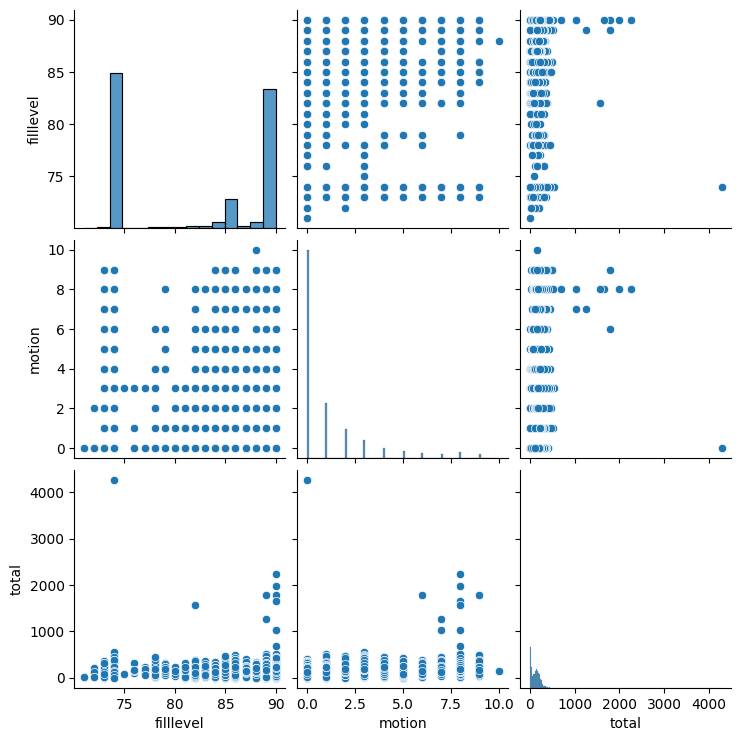

In [463]:
# Create a pairsplot to look at relationships between variables
sns.pairplot(merged_dataframe)
plt.show()

The pairs plot produeced above shows the relationsips between each numerical avriable int eh dataset. It can be seen from this that there is an extreme outlier in the total data column. This value will be removed and scatterplots called again.

In [439]:
# Drop rows where total > 4000
filtered_merged_dataframe = merged_dataframe.drop(merged_dataframe[merged_dataframe['total'] > 4000].index)

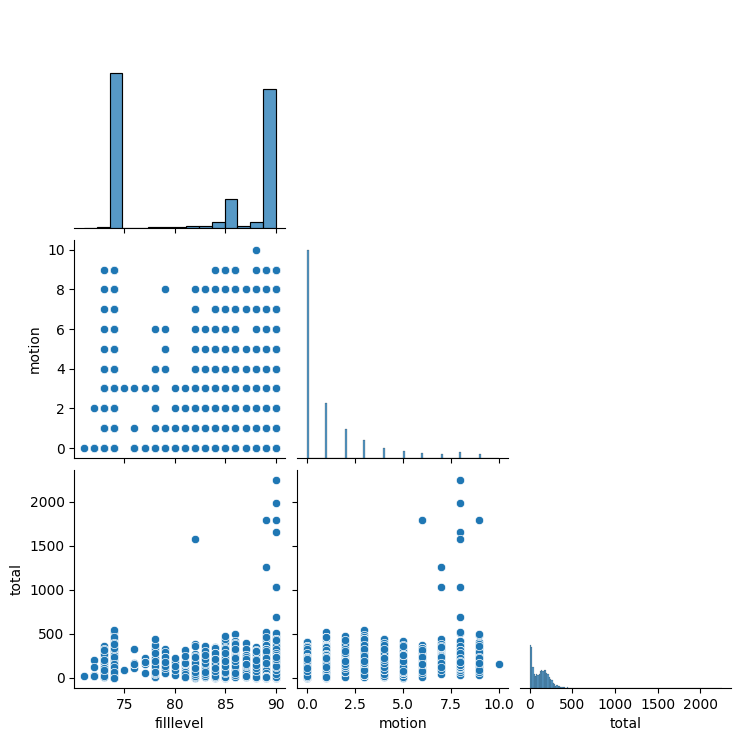

In [464]:
# Create a pairsplot to look at relationships between variables
sns.pairplot(filtered_merged_dataframe, corner=True)
plt.show()

The pairs plot does not shw a clear strong relationship between any sets of variables.

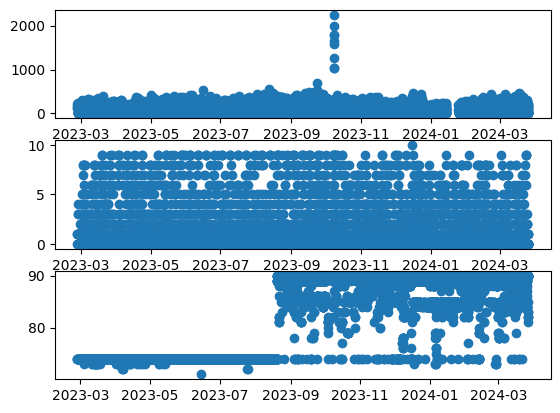

In [465]:
# Create scatter plots  of datetime vs all other variables
# Create a plot of time vs total
plt.subplot(3,1,1)
plt.scatter(filtered_merged_dataframe['date_time'],filtered_merged_dataframe['total'])
# Create a plot of time vs motion
plt.subplot(3,1,2)
plt.scatter(filtered_merged_dataframe['date_time'],filtered_merged_dataframe['motion'])
# Create a plot of time vs filllevel
plt.subplot(3,1,3)
plt.scatter(filtered_merged_dataframe['date_time'], filtered_merged_dataframe['filllevel'])

plt.show()

The scatterplots of variables against time also do not show a distinct pattern emerging. However, from this data it is evident that from 2023-08 the bins were more likely to have higher fill values.As 2023-03 and 2024-03 do not have similar fill value patterns, the data prior to 2023-08-20 will be dropped from the table to determine if clearer patterns emerge from the most recent data.

In [493]:
fmdd = filtered_merged_dataframe[(filtered_merged_dataframe['date_time'] > '2023-08-20')]

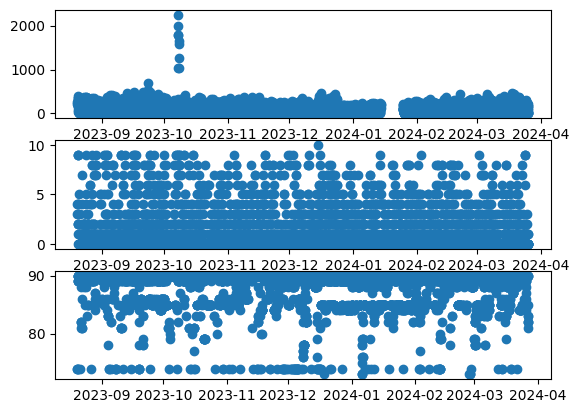

In [494]:
# Create scatter plots  of datetime vs all other variables
# Create a plot of time vs total
plt.subplot(3,1,1)
plt.scatter(fmdd['date_time'],fmdd['total'])
# Create a plot of time vs motion
plt.subplot(3,1,2)
plt.scatter(fmdd['date_time'],fmdd['motion'])
# Create a plot of time vs filllevel
plt.subplot(3,1,3)
plt.scatter(fmdd['date_time'], fmdd['filllevel'])

plt.show()

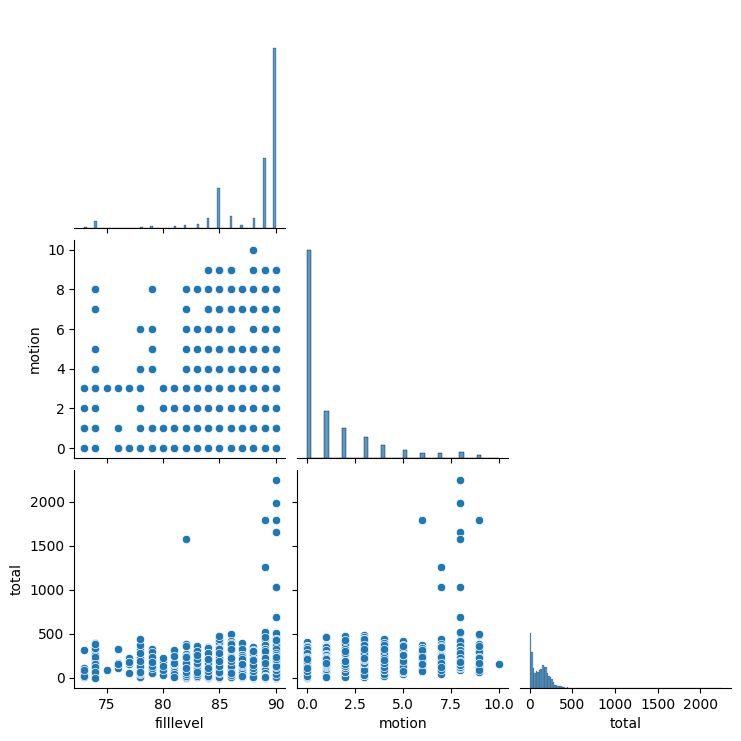

In [495]:
# Create a pairsplot to look at relationships between variables
sns.pairplot(fmdd, corner=True)
plt.show()

Spearman correlation is used to determine extent of linear relationship between each pair of variables. This is used as date_time is a categorical data type (every hour) and all other assumptions for Spearman correlation are assumed met.

In [496]:
# Calculate correlation matrix for all columns
matrix = fmdd.corr(method = 'pearson').round(2)
print(matrix)

           date_time  filllevel  motion  total
date_time       1.00      -0.09   -0.05  -0.13
filllevel      -0.09       1.00   -0.06  -0.08
motion         -0.05      -0.06    1.00   0.49
total          -0.13      -0.08    0.49   1.00


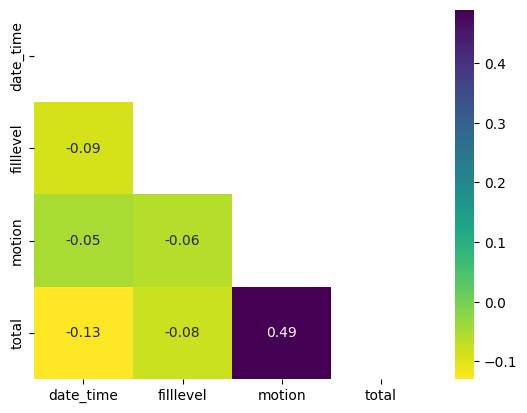

In [497]:
# Calculate correlation heatmap for all columns
matrix = fmdd.corr(method = 'pearson').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, cmap='viridis_r', mask=mask)

plt.show()

The correlation heatmap shows a medium relationsip between motion on the stage and total number of people present from blix phone counts. All other variable pairs show negligable linear correlations. As linear correlations are not strong, will also look at non-linear relationships with distance correlation.

In [503]:
# Drop rows with na values (not supported in dcor package)
no_na_fmdd = fmdd.dropna(axis=0, how='any')

# Calculate distance correlation between variables
print("filllevel and total =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['total']))
print("filllevel and motion =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['motion']))
#print("filllevel and date =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['date_time']))
print("motion and total =" , dcor.distance_correlation(no_na_fmdd['motion'],no_na_fmdd['total']))
#print("motion and date =" , dcor.distance_correlation(no_na_fmdd['motion'],no_na_fmdd['date_time']))
#print("total and date =" , dcor.distance_correlation(no_na_fmdd['date_time'],no_na_fmdd['total']))

filllevel and total = 0.12436600201279792
filllevel and motion = 0.11724798447598182
motion and total = 0.5300383999080241


In [505]:
no_na_fmdd.dtypes


date_time    datetime64[ns, UTC]
filllevel                float64
motion                   float64
total                    float64
dtype: object

Predictions for bin full

In [443]:
#!jupyter nbconvert --to html usecase_TEMPLATE_COPY.ipynb